In [38]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

SAMPLE_SIZE = 500

## Similar Brokerages
There are many reasons that a brokerage would want to know what other companies are similar to them. It can help them understand where they fit in the market and add more context to their own metrics. For example, the average sales price grew by 30% across the city, if a brokerage's average sale price grew by 10%, but the most similar brokerages' average sale price grew by just 5%. Without this information, they would think they are underperforming whereas they are actually doing well when compared to their direct competitors.

## Importing and Encoding Data
The input data is from NYC brokerages. The sql query that generated the data can be found in this directory. The difference between v1 and v2 of `similar_brokerages_nyc.sql` has to do with how the neighborhoods where encoded. In v2, the data is split by neighborhood as well as brokerage, whereas in v1, it was just a unique array of all the neighborhoods that the brokerage had listings in.

This next section will be reading in this data and encoding it -- prepping it for cosine similarity

In [39]:
input_by_b = pd.read_csv('data/NYC_Similar_Brokerages_2024_05_09.csv')#.sample(SAMPLE_SIZE,random_state=42)
input_by_b = input_by_b[input_by_b['agent_count']>=50] # limiting to just brokerages with more than 100 agents
input_by_b['pct_sold'] = input_by_b['sales_count']/input_by_b['total_listing_count']
input_by_b['unique_id'] = input_by_b['id'].astype(str)+': ' + input_by_b['name']

input_by_b.head()

,id,name,brokerage_mls_id,agent_count,total_listing_count,sales_count,avg_sale_price,max_sale_price,pct_sold,unique_id
0,5,Stribling & Associates Ltd,RBNY-1365,1301,19676,11634,2.155001e+06,3.462050e+07,0.591279,5: Stribling & Associates Ltd
1,6,Brown Harris Stevens Residential Sales LLC,RBNY-219,5321,54274,19749,2.173181e+06,1.000000e+09,0.363876,6: Brown Harris Stevens Residential Sales LLC
2,26,Compass,RBNY-7222,4322,87233,20087,1.581053e+06,4.320000e+07,0.230268,26: Compass
3,1180,"CORE Group Marketing, LLC",RBNY-5599,461,8820,3180,2.169481e+06,3.258400e+07,0.360544,"1180: CORE Group Marketing, LLC"
21,1210,Level,RBNY-5416,298,6949,763,1.171445e+06,2.400000e+07,0.109800,1210: Level


In [40]:
input_by_n = pd.read_csv('data/NYC_Similar_Brokerages_2024_05_09 (1).csv')
input_by_n['pct_sold'] = input_by_n['sales_count']/input_by_n['total_listing_count']
input_by_n = input_by_n[['id','name', 'brokerage_mls_id', 'neighborhood_name',
                         'total_listing_count', 'sales_count', 'pct_sold',
                         'avg_sale_price', 'max_sale_price']]

input_by_n.head()

,id,name,brokerage_mls_id,neighborhood_name,total_listing_count,sales_count,pct_sold,avg_sale_price,max_sale_price
0,5,Stribling & Associates Ltd,RBNY-1365,Alphabet City,45,18,0.400000,6.600212e+05,2900000.0
1,5,Stribling & Associates Ltd,RBNY-1365,Auburndale,1,0,0.000000,NaN,NaN
2,5,Stribling & Associates Ltd,RBNY-1365,Battery Park,77,35,0.454545,1.385243e+06,3000000.0
3,5,Stribling & Associates Ltd,RBNY-1365,Bay Ridge,42,16,0.380952,9.558809e+05,4250000.0
4,5,Stribling & Associates Ltd,RBNY-1365,Bed Stuy,38,10,0.263158,1.037917e+06,1600000.0


In [41]:
def transpose_neighborhoods(name, num_listings, num_sales, pct_sold, avg_sale, max_sale,n):
    tmp = {f'{name}_total_listing_count': [num_listings],
           f'{name}_sales_count': [num_sales],
           f'{name}_pct_sold': [pct_sold]}
           #,f'{name}_avg_sale_price': [avg_sale],
           #f'{name}_max_sale_price': [max_sale]}
    return pd.DataFrame(tmp, index=[n])

In [42]:
encoded_brokerages_values = pd.concat([transpose_neighborhoods(name, listings, sales, pct, avg, max_sale, n) for name, listings, sales, pct, avg, max_sale, n in tqdm(zip(input_by_n['neighborhood_name'],
                                                     input_by_n['total_listing_count'],
                                                     input_by_n['sales_count'],
                                                     input_by_n['pct_sold'],
                                                     input_by_n['avg_sale_price'],
                                                     input_by_n['max_sale_price'],
                                                     input_by_n['id']), total=len(input_by_n))], axis=1)

  0%|          | 0/52242 [00:00<?, ?it/s]

In [43]:
encoded_brokerages = pd.DataFrame(encoded_brokerages_values.index)
encoded_brokerages.columns=['brokerage_id']
encoded_brokerages.index=encoded_brokerages['brokerage_id']
cols = [(c,encoded_brokerages_values[c].sum(axis=1)) for c in tqdm(encoded_brokerages_values.columns.unique()
                                                               , total=len(encoded_brokerages_values.columns.unique()))]
cols = [pd.DataFrame({x[0]: x[1]}) for x in cols]

  0%|          | 0/654 [00:00<?, ?it/s]

In [44]:
cols = pd.concat(cols, axis=1)
cols.head()

,Alphabet City_total_listing_count,Alphabet City_sales_count,Alphabet City_pct_sold,Auburndale_total_listing_count,Auburndale_sales_count,Auburndale_pct_sold,Battery Park_total_listing_count,Battery Park_sales_count,Battery Park_pct_sold,Bay Ridge_total_listing_count,...,Westchester Village_pct_sold,West Farms_total_listing_count,West Farms_sales_count,West Farms_pct_sold,Woodlawn_total_listing_count,Woodlawn_sales_count,Woodlawn_pct_sold,Co-op City_total_listing_count,Co-op City_sales_count,Co-op City_pct_sold
5,45.0,18.0,0.400000,1.0,0.0,0.000000,77.0,35.0,0.454545,42.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
6,181.0,36.0,0.198895,0.0,0.0,0.000000,273.0,117.0,0.428571,78.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
26,573.0,118.0,0.205934,56.0,26.0,0.464286,388.0,135.0,0.347938,178.0,...,0.0,5.0,1.0,0.2,6.0,1.0,0.166667,0.0,0.0,0.0
1180,56.0,13.0,0.232143,0.0,0.0,0.000000,55.0,9.0,0.163636,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1182,2.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [45]:
encoded_brokerages = input_by_b.merge(cols,how='inner', left_on='id', right_index=True).drop(columns=['id','name', 'brokerage_mls_id'])
encoded_brokerages.columns = ['brokerage_id'] + list(encoded_brokerages.columns)[1:]
encoded_brokerages.head()

,brokerage_id,total_listing_count,sales_count,avg_sale_price,max_sale_price,pct_sold,unique_id,Alphabet City_total_listing_count,Alphabet City_sales_count,Alphabet City_pct_sold,...,Westchester Village_pct_sold,West Farms_total_listing_count,West Farms_sales_count,West Farms_pct_sold,Woodlawn_total_listing_count,Woodlawn_sales_count,Woodlawn_pct_sold,Co-op City_total_listing_count,Co-op City_sales_count,Co-op City_pct_sold
0,1301,19676,11634,2.155001e+06,3.462050e+07,0.591279,5: Stribling & Associates Ltd,45.0,18.0,0.400000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,5321,54274,19749,2.173181e+06,1.000000e+09,0.363876,6: Brown Harris Stevens Residential Sales LLC,181.0,36.0,0.198895,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,4322,87233,20087,1.581053e+06,4.320000e+07,0.230268,26: Compass,573.0,118.0,0.205934,...,0.0,5.0,1.0,0.2,6.0,1.0,0.166667,0.0,0.0,0.0
3,461,8820,3180,2.169481e+06,3.258400e+07,0.360544,"1180: CORE Group Marketing, LLC",56.0,13.0,0.232143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
21,298,6949,763,1.171445e+06,2.400000e+07,0.109800,1210: Level,24.0,3.0,0.125000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [46]:
x=pd.DataFrame(preprocessing.normalize(encoded_brokerages.set_index('unique_id').drop(columns='brokerage_id').fillna(0),axis=0,norm='l2'))
x.columns = encoded_brokerages.drop(columns=['unique_id', 'brokerage_id']).columns
normalized_brokerages = encoded_brokerages[['unique_id']].merge(x, how='inner', left_index=True, right_index=True)
normalized_brokerages.set_index('unique_id', inplace=True)
normalized_brokerages.head()

,total_listing_count,sales_count,avg_sale_price,max_sale_price,pct_sold,Alphabet City_total_listing_count,Alphabet City_sales_count,Alphabet City_pct_sold,Auburndale_total_listing_count,Auburndale_sales_count,...,Westchester Village_pct_sold,West Farms_total_listing_count,West Farms_sales_count,West Farms_pct_sold,Woodlawn_total_listing_count,Woodlawn_sales_count,Woodlawn_pct_sold,Co-op City_total_listing_count,Co-op City_sales_count,Co-op City_pct_sold
unique_id,,,,,,,,,,,,,,,,,,,,,
5: Stribling & Associates Ltd,0.044810,0.095695,0.125828,0.029618,0.167078,0.016735,0.030310,0.156241,0.001660,0.0000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
6: Brown Harris Stevens Residential Sales LLC,0.123604,0.162445,0.126890,0.855501,0.102821,0.067311,0.060620,0.077689,0.000000,0.0000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
26: Compass,0.198665,0.165225,0.092316,0.036958,0.065067,0.213090,0.198699,0.080438,0.092952,0.0836,...,0.0,0.389249,0.235702,0.100042,0.073269,0.029961,0.049122,0.0,0.0,0.0
"1180: CORE Group Marketing, LLC",0.020087,0.026157,0.126673,0.027876,0.101879,0.020826,0.021891,0.090675,0.000000,0.0000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1210: Level,0.001644,0.000354,0.074778,0.007486,0.016829,0.004834,0.000000,0.000000,0.000000,0.0000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [47]:
print(len(normalized_brokerages.columns))

659


## Cosine Similarity Time

In [48]:
similarity_matrix_dict = {}
for id_a in tqdm(normalized_brokerages.index):
    for id_b in normalized_brokerages.index:
        try:
            similarity_matrix_dict[(id_a, id_b)] = similarity_matrix_dict[(id_b, id_a)]
        except KeyError:
            similarity_matrix_dict[(id_a, id_b)] = cosine_similarity(normalized_brokerages.loc[id_a].values.reshape(1, -1), normalized_brokerages.loc[id_b].values.reshape(1, -1))

  0%|          | 0/27 [00:00<?, ?it/s]

## Visualization Time

In [49]:
similarity_matrix = pd.DataFrame(columns=normalized_brokerages.index, index=normalized_brokerages.index)
for k in tqdm(similarity_matrix_dict.keys(), total=len(similarity_matrix_dict.keys())):
    similarity_matrix.loc[k[0], k[1]] = float(similarity_matrix_dict[k][0][0])
similarity_matrix.head()

  0%|          | 0/729 [00:00<?, ?it/s]

unique_id,5: Stribling & Associates Ltd,6: Brown Harris Stevens Residential Sales LLC,26: Compass,"1180: CORE Group Marketing, LLC",1210: Level,1222: R New York,1251: KWNYC Tribeca,1252: Maz Group NY LLC,1298: Nest Seekers LLC,1305: Corcoran Group,...,"1468: Oxford Property Partners, Inc.",1474: Bond New York Properties LLC,1516: LG Fairmont,1520: Bellmarc Realty LLC,1522: Metropolitan Property Group Inc,1524: Exit Realty Landmark,1525: Keller Williams NYC,"1541: Halstead Property, LLC",1548: Brick & Mortar LLC,"1550: Related Sales, LLC"
unique_id,,,,,,,,,,,,,,,,,,,,,
5: Stribling & Associates Ltd,1.0,0.622126,0.35428,0.611624,0.126339,0.187627,0.396774,0.120392,0.048768,0.100843,...,0.124244,0.149433,0.017548,0.002619,0.007243,0.02308,0.007243,0.004665,0.008658,0.007185
6: Brown Harris Stevens Residential Sales LLC,0.622126,1.0,0.505068,0.46929,0.117053,0.233676,0.235826,0.18561,0.050041,0.076827,...,0.112085,0.128843,0.087143,0.073078,0.069709,0.069862,0.011662,0.08487,0.021463,0.006601
26: Compass,0.35428,0.505068,1.0,0.296894,0.08604,0.264163,0.117212,0.158196,0.107361,0.097146,...,0.155541,0.200267,0.192737,0.080873,0.152897,0.128204,0.028764,0.051354,0.039742,0.009136
"1180: CORE Group Marketing, LLC",0.611624,0.46929,0.296894,1.0,0.158565,0.190067,0.351678,0.116888,0.045196,0.078683,...,0.139807,0.191407,0.040993,0.073982,0.035641,0.034165,0.022483,0.035314,0.018936,0.008977
1210: Level,0.126339,0.117053,0.08604,0.158565,1.0,0.067454,0.113731,0.033445,0.05714,0.075759,...,0.24969,0.0809,0.026708,0.004036,0.002575,0.003984,0.097656,0.008419,0.011293,0.013454


In [50]:
del input_by_b, input_by_n, similarity_matrix_dict, encoded_brokerages_values, encoded_brokerages, normalized_brokerages, cols
similarity_matrix = similarity_matrix.apply(pd.to_numeric)

[Text(0.5, 0, '5: Stribling & Associates Ltd'),
 Text(1.5, 0, '6: Brown Harris Stevens Residential Sales LLC'),
 Text(2.5, 0, '26: Compass'),
 Text(3.5, 0, '1180: CORE Group Marketing, LLC'),
 Text(4.5, 0, '1210: Level'),
 Text(5.5, 0, '1222: R New York'),
 Text(6.5, 0, '1251: KWNYC Tribeca'),
 Text(7.5, 0, '1252: Maz Group NY LLC'),
 Text(8.5, 0, '1298: Nest Seekers LLC'),
 Text(9.5, 0, '1305: Corcoran Group'),
 Text(10.5, 0, '1309: Real New York'),
 Text(11.5, 0, '1343: City Connections Realty Inc'),
 Text(12.5, 0, '1365: Nancy Packes Inc'),
 Text(13.5, 0, '1369: Living New York'),
 Text(14.5, 0, '1392: Massey Knakal Realty of Manhattan, LLC'),
 Text(15.5, 0, '1427: VORO NYC'),
 Text(16.5, 0, '1464: Ideal Properties Group LLC'),
 Text(17.5, 0, '1468: Oxford Property Partners, Inc.'),
 Text(18.5, 0, '1474: Bond New York Properties LLC'),
 Text(19.5, 0, '1516: LG Fairmont'),
 Text(20.5, 0, '1520: Bellmarc Realty LLC'),
 Text(21.5, 0, '1522: Metropolitan Property Group Inc'),
 Text(22.5

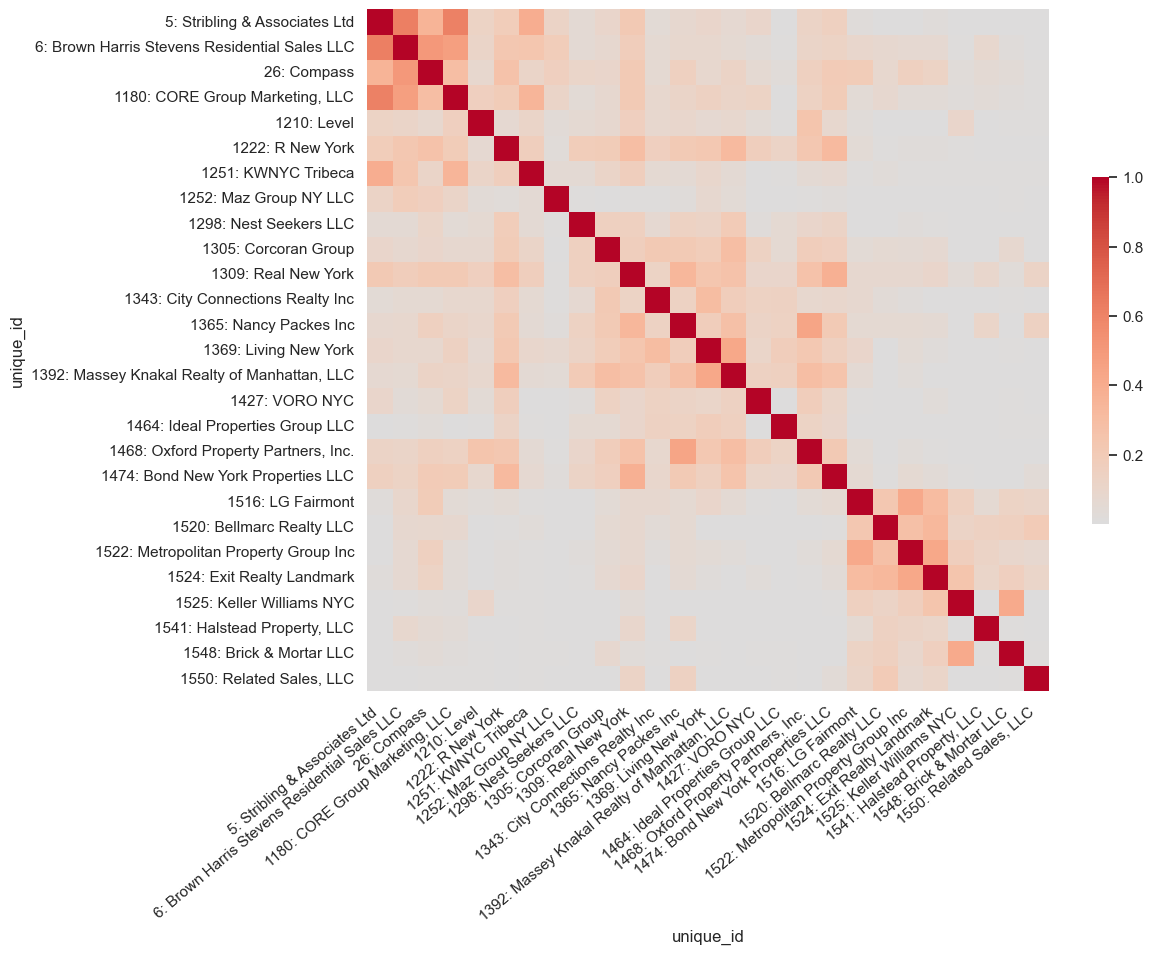

In [51]:
import numpy as np
sns.set_theme()
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.color_palette("coolwarm", as_cmap=True)
# Draw a heatmap with the numeric values in each cell
sns.heatmap(similarity_matrix, cmap=cmap, vmax=1, center=0, #mask=mask,
            square=True, cbar_kws={"shrink": .5})
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

In [52]:
similarity_matrix.to_csv(f'data/nyc_similar_brokerages_n{SAMPLE_SIZE}.csv')

## Exploring the Output

In [53]:
similarity_matrix.head()

unique_id,5: Stribling & Associates Ltd,6: Brown Harris Stevens Residential Sales LLC,26: Compass,"1180: CORE Group Marketing, LLC",1210: Level,1222: R New York,1251: KWNYC Tribeca,1252: Maz Group NY LLC,1298: Nest Seekers LLC,1305: Corcoran Group,...,"1468: Oxford Property Partners, Inc.",1474: Bond New York Properties LLC,1516: LG Fairmont,1520: Bellmarc Realty LLC,1522: Metropolitan Property Group Inc,1524: Exit Realty Landmark,1525: Keller Williams NYC,"1541: Halstead Property, LLC",1548: Brick & Mortar LLC,"1550: Related Sales, LLC"
unique_id,,,,,,,,,,,,,,,,,,,,,
5: Stribling & Associates Ltd,1.000000,0.622126,0.354280,0.611624,0.126339,0.187627,0.396774,0.120392,0.048768,0.100843,...,0.124244,0.149433,0.017548,0.002619,0.007243,0.023080,0.007243,0.004665,0.008658,0.007185
6: Brown Harris Stevens Residential Sales LLC,0.622126,1.000000,0.505068,0.469290,0.117053,0.233676,0.235826,0.185610,0.050041,0.076827,...,0.112085,0.128843,0.087143,0.073078,0.069709,0.069862,0.011662,0.084870,0.021463,0.006601
26: Compass,0.354280,0.505068,1.000000,0.296894,0.086040,0.264163,0.117212,0.158196,0.107361,0.097146,...,0.155541,0.200267,0.192737,0.080873,0.152897,0.128204,0.028764,0.051354,0.039742,0.009136
"1180: CORE Group Marketing, LLC",0.611624,0.469290,0.296894,1.000000,0.158565,0.190067,0.351678,0.116888,0.045196,0.078683,...,0.139807,0.191407,0.040993,0.073982,0.035641,0.034165,0.022483,0.035314,0.018936,0.008977
1210: Level,0.126339,0.117053,0.086040,0.158565,1.000000,0.067454,0.113731,0.033445,0.057140,0.075759,...,0.249690,0.080900,0.026708,0.004036,0.002575,0.003984,0.097656,0.008419,0.011293,0.013454


In [54]:
similarity_matrix[similarity_matrix.columns[0]].sort_values(ascending=False)[1:12]

unique_id
6: Brown Harris Stevens Residential Sales LLC    0.622126
1180: CORE Group Marketing, LLC                  0.611624
1251: KWNYC Tribeca                              0.396774
26: Compass                                      0.354280
1309: Real New York                              0.212391
1222: R New York                                 0.187627
1474: Bond New York Properties LLC               0.149433
1210: Level                                      0.126339
1468: Oxford Property Partners, Inc.             0.124244
1252: Maz Group NY LLC                           0.120392
1369: Living New York                            0.101285
Name: 5: Stribling & Associates Ltd, dtype: float64

In [55]:
input_by_b = pd.read_csv('data/NYC_Similar_Brokerages_2024_05_09.csv')#.sample(SAMPLE_SIZE,random_state=42)
input_by_b['pct_sold'] = input_by_b['sales_count']/input_by_b['total_listing_count']
input_by_b['unique_id'] = input_by_b['id'].astype(str)+': ' + input_by_b['name']

input_by_b.head()

,id,name,brokerage_mls_id,agent_count,total_listing_count,sales_count,avg_sale_price,max_sale_price,pct_sold,unique_id
0,5,Stribling & Associates Ltd,RBNY-1365,1301,19676,11634,2.155001e+06,3.462050e+07,0.591279,5: Stribling & Associates Ltd
1,6,Brown Harris Stevens Residential Sales LLC,RBNY-219,5321,54274,19749,2.173181e+06,1.000000e+09,0.363876,6: Brown Harris Stevens Residential Sales LLC
2,26,Compass,RBNY-7222,4322,87233,20087,1.581053e+06,4.320000e+07,0.230268,26: Compass
3,1180,"CORE Group Marketing, LLC",RBNY-5599,461,8820,3180,2.169481e+06,3.258400e+07,0.360544,"1180: CORE Group Marketing, LLC"
4,1182,All Area Brokerage Inc,RBNY-7766,12,420,137,3.080379e+05,4.195000e+06,0.326190,1182: All Area Brokerage Inc


In [56]:
input_by_n = pd.read_csv('data/NYC_Similar_Brokerages_2024_05_09 (1).csv')
input_by_n['pct_sold'] = input_by_n['sales_count']/input_by_n['total_listing_count']
input_by_n = input_by_n[['id','name', 'brokerage_mls_id', 'neighborhood_name',
                         'total_listing_count', 'sales_count', 'pct_sold',
                         'avg_sale_price', 'max_sale_price']]

input_by_n.head()

,id,name,brokerage_mls_id,neighborhood_name,total_listing_count,sales_count,pct_sold,avg_sale_price,max_sale_price
0,5,Stribling & Associates Ltd,RBNY-1365,Alphabet City,45,18,0.400000,6.600212e+05,2900000.0
1,5,Stribling & Associates Ltd,RBNY-1365,Auburndale,1,0,0.000000,NaN,NaN
2,5,Stribling & Associates Ltd,RBNY-1365,Battery Park,77,35,0.454545,1.385243e+06,3000000.0
3,5,Stribling & Associates Ltd,RBNY-1365,Bay Ridge,42,16,0.380952,9.558809e+05,4250000.0
4,5,Stribling & Associates Ltd,RBNY-1365,Bed Stuy,38,10,0.263158,1.037917e+06,1600000.0


In [57]:
# import random
# random.seed(2)
# random_id = random.sample(sorted(similarity_matrix.columns),1)[0]
random_id = similarity_matrix.columns[0]

In [58]:
input_by_b[input_by_b['unique_id'] == random_id]

,id,name,brokerage_mls_id,agent_count,total_listing_count,sales_count,avg_sale_price,max_sale_price,pct_sold,unique_id
0,5,Stribling & Associates Ltd,RBNY-1365,1301,19676,11634,2.155001e+06,34620500.0,0.591279,5: Stribling & Associates Ltd


In [85]:
input_by_b[input_by_b['unique_id'].isin(similarity_matrix[random_id].sort_values(ascending=False).index[1:6])]

,id,name,brokerage_mls_id,agent_count,total_listing_count,sales_count,avg_sale_price,max_sale_price,pct_sold,unique_id
1,6,Brown Harris Stevens Residential Sales LLC,RBNY-219,5321,54274,19749,2.173181e+06,1.000000e+09,0.363876,6: Brown Harris Stevens Residential Sales LLC
2,26,Compass,RBNY-7222,4322,87233,20087,1.581053e+06,4.320000e+07,0.230268,26: Compass
3,1180,"CORE Group Marketing, LLC",RBNY-5599,461,8820,3180,2.169481e+06,3.258400e+07,0.360544,"1180: CORE Group Marketing, LLC"
41,1251,KWNYC Tribeca,RBNY-7871,218,2441,352,1.158735e+06,1.550000e+07,0.144203,1251: KWNYC Tribeca
82,1309,Real New York,RBNY-7351,262,12069,115,1.076806e+06,6.375000e+06,0.009529,1309: Real New York


In [60]:
similarity_matrix[random_id].sort_values(ascending=False).index[1].split(':')[0]

'6'

In [86]:
check_1 = input_by_n[input_by_n['id'] == int(similarity_matrix[random_id].sort_values(ascending=False).index[2].split(':')[0])]
check_0 = input_by_n[input_by_n['id'] == int(random_id.split(':')[0])]

In [87]:
check_0.head()

,id,name,brokerage_mls_id,neighborhood_name,total_listing_count,sales_count,pct_sold,avg_sale_price,max_sale_price
0,5,Stribling & Associates Ltd,RBNY-1365,Alphabet City,45,18,0.400000,6.600212e+05,2900000.0
1,5,Stribling & Associates Ltd,RBNY-1365,Auburndale,1,0,0.000000,NaN,NaN
2,5,Stribling & Associates Ltd,RBNY-1365,Battery Park,77,35,0.454545,1.385243e+06,3000000.0
3,5,Stribling & Associates Ltd,RBNY-1365,Bay Ridge,42,16,0.380952,9.558809e+05,4250000.0
4,5,Stribling & Associates Ltd,RBNY-1365,Bed Stuy,38,10,0.263158,1.037917e+06,1600000.0


In [88]:
pd.concat([check_0[['name', 'neighborhood_name', 'total_listing_count']],
            check_1[['name', 'neighborhood_name', 'total_listing_count']]])

,name,neighborhood_name,total_listing_count
0,Stribling & Associates Ltd,Alphabet City,45
1,Stribling & Associates Ltd,Auburndale,1
2,Stribling & Associates Ltd,Battery Park,77
3,Stribling & Associates Ltd,Bay Ridge,42
4,Stribling & Associates Ltd,Bed Stuy,38
...,...,...,...
595,"CORE Group Marketing, LLC",Windsor Terrace,20
596,"CORE Group Marketing, LLC",Woodhaven,5
597,"CORE Group Marketing, LLC",Woodside,17
598,"CORE Group Marketing, LLC",Yorkville,230


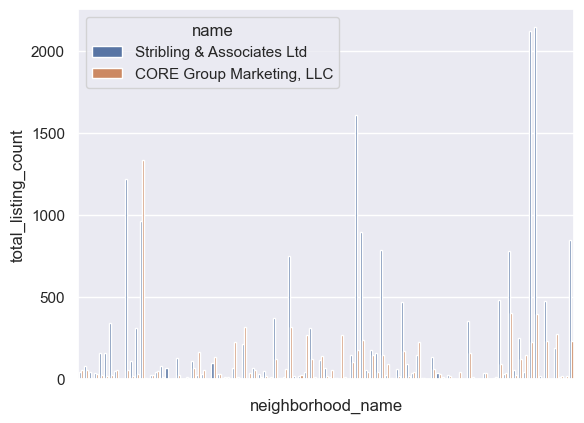

In [89]:
plt_df = pd.concat([check_0[check_0['neighborhood_name'].isin(check_1['neighborhood_name'])][['name', 'neighborhood_name', 'total_listing_count']],
            check_1[check_1['neighborhood_name'].isin(check_0['neighborhood_name'])][['name', 'neighborhood_name', 'total_listing_count']]])
sns.barplot(plt_df,
            x='neighborhood_name', y='total_listing_count', hue='name').set(xticklabels=[])
plt.show()

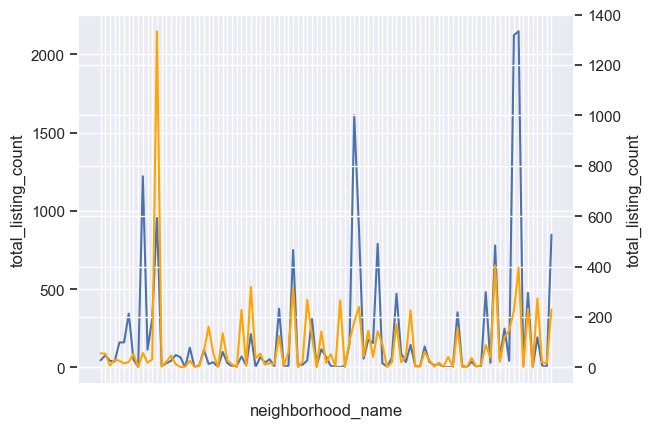

In [90]:
g1 = sns.lineplot(data=check_0[check_0['neighborhood_name'].isin(check_1['neighborhood_name'])], x='neighborhood_name', y='total_listing_count', color="b")
ax2 = plt.twinx()
g2 = sns.lineplot(data=check_1[check_1['neighborhood_name'].isin(check_0['neighborhood_name'])], x='neighborhood_name', y='total_listing_count', color="orange", ax=ax2)
g1.set(xticklabels=[])
g2.set(xticklabels=[])
plt.show()

In [91]:
check_0[['name', 'neighborhood_name', 'total_listing_count']].sort_values(by='total_listing_count', ascending=False)[:10]

,name,neighborhood_name,total_listing_count
104,Stribling & Associates Ltd,Upper West Side,2148
103,Stribling & Associates Ltd,Upper East Side,2123
61,Stribling & Associates Ltd,Lenox Hill,1612
14,Stribling & Associates Ltd,Carnegie Hill,1221
17,Stribling & Associates Ltd,Chelsea,964
62,Stribling & Associates Ltd,Lincoln Square,899
111,Stribling & Associates Ltd,Yorkville,848
67,Stribling & Associates Ltd,Midtown Central,790
99,Stribling & Associates Ltd,TriBeCa,779
48,Stribling & Associates Ltd,Greenwich Village,750


In [92]:
check_1[['name', 'neighborhood_name', 'total_listing_count']].sort_values(by='total_listing_count', ascending=False)[:10]

,name,neighborhood_name,total_listing_count
500,"CORE Group Marketing, LLC",Chelsea,1334
584,"CORE Group Marketing, LLC",TriBeCa,405
589,"CORE Group Marketing, LLC",Upper West Side,396
522,"CORE Group Marketing, LLC",Flatiron,320
533,"CORE Group Marketing, LLC",Greenwich Village,318
599,"CORE Group Marketing, LLC",NaN,279
594,"CORE Group Marketing, LLC",Williamsburg,274
536,"CORE Group Marketing, LLC",Harlem,268
543,"CORE Group Marketing, LLC",Jackson Heights,266
548,"CORE Group Marketing, LLC",Lincoln Square,241


In [93]:
n = check_0['name'].unique()[0]
check_0 = check_0[['neighborhood_name', 'total_listing_count']]
check_0.columns = ['neighborhood_name', n]

In [94]:
n = check_1['name'].unique()[0]
check_1 = check_1[['neighborhood_name', 'total_listing_count']]
check_1.columns = ['neighborhood_name', n]

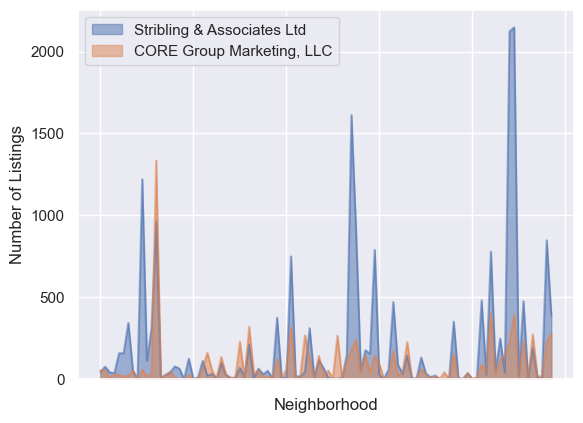

In [95]:
ax = check_0.merge(right=check_1, how='inner', on='neighborhood_name').plot.area(stacked=False)
ax.set(xticklabels=[])
ax.set(xlabel='Neighborhood')
ax.set(ylabel='Number of Listings')
plt.show()

In [96]:
similarity_matrix[random_id].sort_values(ascending=False)

unique_id
5: Stribling & Associates Ltd                    1.000000
6: Brown Harris Stevens Residential Sales LLC    0.622126
1180: CORE Group Marketing, LLC                  0.611624
1251: KWNYC Tribeca                              0.396774
26: Compass                                      0.354280
1309: Real New York                              0.212391
1222: R New York                                 0.187627
1474: Bond New York Properties LLC               0.149433
1210: Level                                      0.126339
1468: Oxford Property Partners, Inc.             0.124244
1252: Maz Group NY LLC                           0.120392
1369: Living New York                            0.101285
1305: Corcoran Group                             0.100843
1427: VORO NYC                                   0.098828
1365: Nancy Packes Inc                           0.076650
1392: Massey Knakal Realty of Manhattan, LLC     0.065792
1298: Nest Seekers LLC                           0.048768
1343